In [31]:
!pip install keras-tuner
!pip install scikit-optimize

****

# **NFL_SCORES**


****

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = 'nfl_scores.csv'

data = []
with open(file_path, 'r') as file:
    temp_dict = {}
    for line in file:
        key_value = line.strip().split(': ')
        if len(key_value) == 2:
            key, value = key_value[0], key_value[1]
            if key == 'Season':
                if temp_dict:
                    data.append(temp_dict)
                    temp_dict = {}
                temp_dict['Season'] = value
            elif key == 'Week':
                temp_dict['Week'] = int(value)
            elif key in ['Home Team', 'Away Team']:
                parts = value.split(' (')
                if len(parts) == 2:
                    team, score = parts[0], parts[1].strip(')')
                    try:
                        temp_dict[key] = team
                        temp_dict[key.replace('Team', 'Score')] = int(score)
                    except ValueError:
                        print(f"Error parsing score from line: {line.strip()}")
                        temp_dict[key.replace('Team', 'Score')] = None
                else:
                    print(f"Malformed line detected: {line.strip()}")
                    temp_dict[key] = parts[0] if parts else 'Unknown'
                    temp_dict[key.replace('Team', 'Score')] = None

    if temp_dict:
        data.append(temp_dict)

nfl_df = pd.DataFrame(data)

season_categories = [f"{year} {season}" for year in range(2016, 2024) for season in ["PRE", "REG", "POST"]]
nfl_df['Season'] = pd.Categorical(nfl_df['Season'], categories=season_categories, ordered=True)

if 'Week' in nfl_df.columns:
    nfl_df['Week'] = pd.to_numeric(nfl_df['Week'], errors='coerce')

if 'Season' in nfl_df.columns and 'Week' in nfl_df.columns:
    nfl_sorted = nfl_df.sort_values(by=['Season', 'Week'])
    print(nfl_sorted)
else:
    print("Required columns for sorting are missing.")

nfl_sorted


Error parsing score from line: Home Team: MIA (None)
Error parsing score from line: Away Team: TB (None)
Error parsing score from line: Home Team: TEN (None)
Error parsing score from line: Away Team: PIT (None)
Error parsing score from line: Home Team: NE (None)
Error parsing score from line: Away Team: DEN (None)
Error parsing score from line: Home Team: DEN (None)
Error parsing score from line: Away Team: MIA (None)
Error parsing score from line: Home Team: LAC (None)
Error parsing score from line: Away Team: NYJ (None)
Error parsing score from line: Home Team: MIA (None)
Error parsing score from line: Away Team: LAC (None)
Error parsing score from line: Home Team: BAL (None)
Error parsing score from line: Away Team: PIT (None)
Error parsing score from line: Home Team: LAC (None)
Error parsing score from line: Away Team: JAX (None)
Error parsing score from line: Home Team: MIA (None)
Error parsing score from line: Away Team: NYJ (None)
Error parsing score from line: Home Team: DEN (N

,Season,Week,Home Team,Home Score,Away Team,Away Score
257,2017 PRE,1,CAR,18.0,HOU,12.0
258,2017 PRE,1,MIA,16.0,ATL,14.0
259,2017 PRE,1,BUF,5.0,MIN,12.0
260,2017 PRE,1,BAL,16.0,WAS,1.0
261,2017 PRE,1,NE,16.0,JAX,21.0
...,...,...,...,...,...,...
2282,2023 POST,2,BUF,35.0,KC,40.0
2283,2023 POST,2,DET,46.0,TB,34.0
2284,2023 POST,3,SF,47.0,DET,43.0
2285,2023 POST,3,BAL,14.0,KC,24.0


In [33]:
nfl_sorted[nfl_sorted.isnull().any(axis=1)]

,Season,Week,Home Team,Home Score,Away Team,Away Score
7,2017 REG,1,MIA,NaN,TB,NaN
1260,2020 PRE,1,ATL,NaN,MIA,NaN
1261,2020 PRE,1,PIT,NaN,TB,NaN
1262,2020 PRE,1,CHI,NaN,CLE,NaN
1263,2020 PRE,1,GB,NaN,ARI,NaN
...,...,...,...,...,...,...
1096,2020 REG,7,BAL,NaN,PIT,NaN
1113,2020 REG,8,LAC,NaN,JAX,NaN
1142,2020 REG,10,MIA,NaN,NYJ,NaN
1158,2020 REG,11,DEN,NaN,LAC,NaN


In [34]:
median_home_score = nfl_sorted['Home Score'].median()
median_away_score = nfl_sorted['Away Score'].median()

nfl_sorted['Home Score'].fillna(median_home_score, inplace=True)
nfl_sorted['Away Score'].fillna(median_away_score, inplace=True)

nfl_sorted['Home Score'] = nfl_sorted['Home Score'].astype(int)
nfl_sorted['Away Score'] = nfl_sorted['Away Score'].astype(int)

In [35]:
nfl_sorted[nfl_sorted.isnull().any(axis=1)]

,Season,Week,Home Team,Home Score,Away Team,Away Score


****


# **Player_Stats**


****

In [36]:
import pandas as pd
import numpy as np

file_path = 'player_stats.csv'

data = []
with open(file_path, 'r') as file:
    temp_dict = {}
    for line in file:
        key_value = line.strip().split(': ')
        if len(key_value) == 2:
            key, value = key_value[0].strip(), key_value[1].strip()
            if value == 'N/A':
                value = None
            if key == 'Player':
                if temp_dict:
                    data.append(temp_dict)
                    temp_dict = {}
            temp_dict[key] = value

    if temp_dict:
        data.append(temp_dict)

player_df = pd.DataFrame(data)

numeric_fields = ['Passing Yards', 'Passing Touchdowns', 'Interceptions', 'Rushing Yards',
                  'Receiving Yards', 'Receiving Touchdowns', 'Tackles', 'Tackles for Loss',
                  'Sacks', 'Fumbles Recovered', 'Receptions', 'Sacks Allowed', 'Rushing Touchdowns', 'Punts', 'Punt Average', 'Field Goals Made', 'Extra Points Made']
for field in numeric_fields:
    if field in player_df.columns:
        player_df[field] = pd.to_numeric(player_df[field], errors='coerce')

positions = ['OT', 'C', 'G', 'OL', 'LS']
ol_players = player_df['Position'].isin(positions)
sacks_allowed_threshold = (1, 3)
holding_penalties_threshold = (0, 2)

player_df.loc[ol_players, 'Sacks Allowed'] = np.random.randint(sacks_allowed_threshold[0], sacks_allowed_threshold[1] + 1, size=ol_players.sum())
player_df.loc[ol_players, 'Holding Penalties'] = np.random.randint(holding_penalties_threshold[0], holding_penalties_threshold[1] + 1, size=ol_players.sum())

player_df[numeric_fields] = player_df[numeric_fields].fillna(0)

season_categories = [str(year) for year in range(1990, 2025)]
player_df['Season'] = pd.Categorical(player_df['Season'], categories=season_categories, ordered=True)

player_sorted = player_df.sort_values(by=['Season', 'Team'])

player_sorted

,Player,Season,Position,Team,Tackles,Tackles for Loss,Interceptions,Sacks,Fumbles Recovered,Sacks Allowed,...,Receiving Touchdowns,Passing Yards,Passing Touchdowns,Rushing Yards,Rushing Touchdowns,Receptions,Punts,Punt Average,Field Goals Made,Extra Points Made
19,D.Brown,2001,QB,ARI,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,A.Bowers,2001,DE,ARI,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,T.Junkin,2001,LS,ARI,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58,C.Chavous,2001,CB,ARI,55.9,1.1,0.6,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60,M.Gruttadauria,2001,C,ARI,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48653,A.Jones Jr.,2023,DE,WAS,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48668,R.Stromberg,2023,C,WAS,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48744,J.Pryor,2023,DE,WAS,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48759,N.Whiteside,2023,CB,WAS,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
player_sorted[player_sorted.isnull().any(axis=1)]

,Player,Season,Position,Team,Tackles,Tackles for Loss,Interceptions,Sacks,Fumbles Recovered,Sacks Allowed,...,Receiving Touchdowns,Passing Yards,Passing Touchdowns,Rushing Yards,Rushing Touchdowns,Receptions,Punts,Punt Average,Field Goals Made,Extra Points Made
19,D.Brown,2001,QB,ARI,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,A.Bowers,2001,DE,ARI,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58,C.Chavous,2001,CB,ARI,55.9,1.1,0.6,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,R.Moore,2001,WR,ARI,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
117,P.Tillman,2001,SS,ARI,71.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48614,M.Tinsley,2023,WR,WAS,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48653,A.Jones Jr.,2023,DE,WAS,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48744,J.Pryor,2023,DE,WAS,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48759,N.Whiteside,2023,CB,WAS,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
player_sorted.iloc[:40]

,Player,Season,Position,Team,Tackles,Tackles for Loss,Interceptions,Sacks,Fumbles Recovered,Sacks Allowed,...,Receiving Touchdowns,Passing Yards,Passing Touchdowns,Rushing Yards,Rushing Touchdowns,Receptions,Punts,Punt Average,Field Goals Made,Extra Points Made
19,D.Brown,2001,QB,ARI,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,A.Bowers,2001,DE,ARI,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,T.Junkin,2001,LS,ARI,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58,C.Chavous,2001,CB,ARI,55.9,1.1,0.6,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60,M.Gruttadauria,2001,C,ARI,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,R.Moore,2001,WR,ARI,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
117,P.Tillman,2001,SS,ARI,71.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
141,M.Shipp,2001,RB,ARI,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
190,J.Rutledge,2001,LB,ARI,4.6,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,M.Young,2001,LB,ARI,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


****


# **NFL_Standings**

****

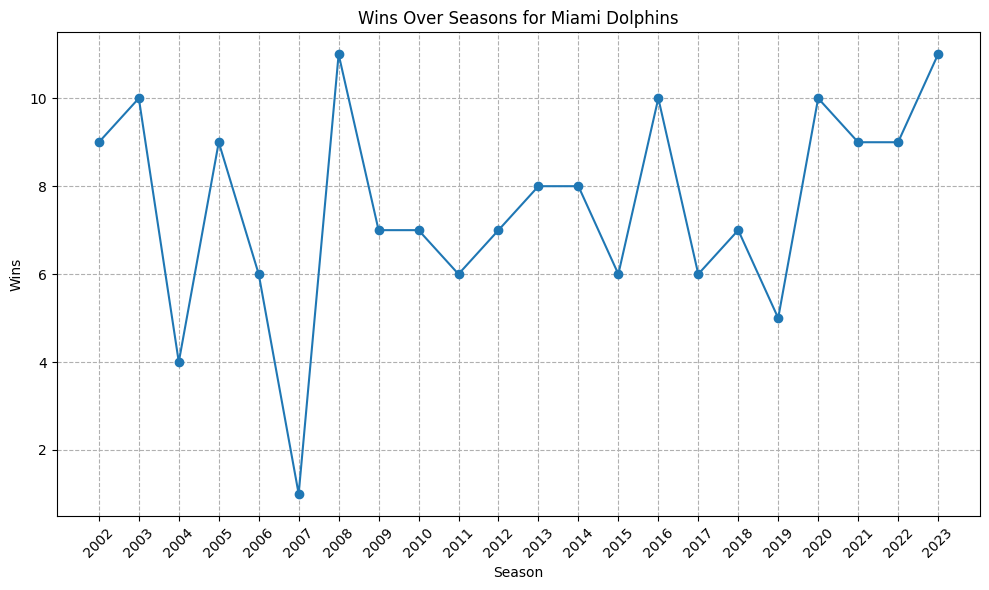

In [39]:
file_path = 'nfl_standings.csv'

data = []
with open(file_path, 'r') as file:
    temp_dict = {}
    for line in file:
        key_value = line.strip().split(': ')
        if len(key_value) == 2:
            key, value = key_value[0].strip(), key_value[1].strip()
            if key == 'Team':
                if temp_dict:
                    data.append(temp_dict)
                    temp_dict = {}
            temp_dict[key] = value

    if temp_dict:
        data.append(temp_dict)

team_df = pd.DataFrame(data)

numeric_fields = ['Wins', 'Losses']
for field in numeric_fields:
    team_df[field] = pd.to_numeric(team_df[field], errors='coerce')

team_df['Season'] = pd.Categorical(team_df['Season'], ordered=True)

team_sorted = team_df.sort_values(by=['Season', 'Conference', 'Division', 'Team'])

jets_data = team_sorted[team_sorted['Team'] == 'Miami Dolphins']
plt.figure(figsize=(10, 6))
plt.plot(jets_data['Season'], jets_data['Wins'], marker='o')
plt.title('Wins Over Seasons for Miami Dolphins')
plt.xlabel('Season')
plt.ylabel('Wins')
plt.grid(True, linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [40]:
team_sorted[team_sorted.isnull().any(axis=1)]

,Team,Season,Wins,Losses,Conference,Division


In [41]:
team_sorted

,Team,Season,Wins,Losses,Conference,Division
3,Buffalo Bills,2002,8,8,AFC,East
0,Miami Dolphins,2002,9,7,AFC,East
1,New England Patriots,2002,9,7,AFC,East
2,New York Jets,2002,9,7,AFC,East
6,Baltimore Ravens,2002,7,9,AFC,North
...,...,...,...,...,...,...
696,Tampa Bay Buccaneers,2023,9,8,NFC,South
703,Arizona Cardinals,2023,4,13,NFC,West
701,Los Angeles Rams,2023,10,7,NFC,West
700,San Francisco 49ers,2023,12,5,NFC,West


****


# **Combine DataFrames**

****

In [42]:
combined_df = pd.concat([nfl_sorted, player_sorted, team_sorted], ignore_index=True)

combined_df_sorted = combined_df.sort_values(by=['Season', 'Week', 'Team', 'Conference'])

combined_df_sorted[['Year', 'Season_Type']] = combined_df_sorted['Season'].str.split(' ', expand=True)

combined_df_sorted['Year'] = pd.to_numeric(combined_df_sorted['Year'], errors='coerce')

combined_df_sorted.fillna("N/A", inplace=True)

combined_df_sorted.replace("N/A", np.nan, inplace=True)

combined_df_sorted = combined_df_sorted.drop(['Season'], axis=1)

combined_df_sorted = combined_df_sorted.sort_values(by=['Year', 'Week', 'Team', 'Conference'])

combined_df_sorted

,Week,Home Team,Home Score,Away Team,Away Score,Player,Position,Team,Tackles,Tackles for Loss,...,Punts,Punt Average,Field Goals Made,Extra Points Made,Wins,Losses,Conference,Division,Year,Season_Type
2287,NaN,NaN,NaN,NaN,NaN,D.Brown,QB,ARI,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,2001,NaN
2288,NaN,NaN,NaN,NaN,NaN,A.Bowers,DE,ARI,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,2001,NaN
2289,NaN,NaN,NaN,NaN,NaN,T.Junkin,LS,ARI,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,2001,NaN
2290,NaN,NaN,NaN,NaN,NaN,C.Chavous,CB,ARI,55.9,1.1,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,2001,NaN
2291,NaN,NaN,NaN,NaN,NaN,M.Gruttadauria,C,ARI,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,2001,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51062,NaN,NaN,NaN,NaN,NaN,R.Stromberg,C,WAS,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,2023,NaN
51063,NaN,NaN,NaN,NaN,NaN,J.Pryor,DE,WAS,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,2023,NaN
51064,NaN,NaN,NaN,NaN,NaN,N.Whiteside,CB,WAS,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,2023,NaN
51065,NaN,NaN,NaN,NaN,NaN,J.Harris,DE,WAS,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,2023,NaN


In [43]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
numeric_columns = combined_df_sorted.select_dtypes(include=[np.number]).columns
combined_df_sorted[numeric_columns] = imputer.fit_transform(combined_df_sorted[numeric_columns])

combined_df_sorted

,Week,Home Team,Home Score,Away Team,Away Score,Player,Position,Team,Tackles,Tackles for Loss,...,Punts,Punt Average,Field Goals Made,Extra Points Made,Wins,Losses,Conference,Division,Year,Season_Type
2287,7.0,NaN,20.0,NaN,18.0,D.Brown,QB,ARI,0.0,0.0,...,0.0,0.0,0.0,0.0,8.0,8.0,NaN,NaN,2001.0,NaN
2288,7.0,NaN,20.0,NaN,18.0,A.Bowers,DE,ARI,0.0,0.0,...,0.0,0.0,0.0,0.0,8.0,8.0,NaN,NaN,2001.0,NaN
2289,7.0,NaN,20.0,NaN,18.0,T.Junkin,LS,ARI,0.0,0.0,...,0.0,0.0,0.0,0.0,8.0,8.0,NaN,NaN,2001.0,NaN
2290,7.0,NaN,20.0,NaN,18.0,C.Chavous,CB,ARI,55.9,1.1,...,0.0,0.0,0.0,0.0,8.0,8.0,NaN,NaN,2001.0,NaN
2291,7.0,NaN,20.0,NaN,18.0,M.Gruttadauria,C,ARI,0.0,0.0,...,0.0,0.0,0.0,0.0,8.0,8.0,NaN,NaN,2001.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51062,7.0,NaN,20.0,NaN,18.0,R.Stromberg,C,WAS,0.0,0.0,...,0.0,0.0,0.0,0.0,8.0,8.0,NaN,NaN,2023.0,NaN
51063,7.0,NaN,20.0,NaN,18.0,J.Pryor,DE,WAS,0.0,0.0,...,0.0,0.0,0.0,0.0,8.0,8.0,NaN,NaN,2023.0,NaN
51064,7.0,NaN,20.0,NaN,18.0,N.Whiteside,CB,WAS,0.0,0.0,...,0.0,0.0,0.0,0.0,8.0,8.0,NaN,NaN,2023.0,NaN
51065,7.0,NaN,20.0,NaN,18.0,J.Harris,DE,WAS,0.0,0.0,...,0.0,0.0,0.0,0.0,8.0,8.0,NaN,NaN,2023.0,NaN


In [44]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = combined_df_sorted.select_dtypes(include=['object', 'category']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    combined_df_sorted[col] = le.fit_transform(combined_df_sorted[col].astype(str))
    label_encoders[col] = le

In [45]:
print(combined_df_sorted.columns)

Index(['Week', 'Home Team', 'Home Score', 'Away Team', 'Away Score', 'Player',
       'Position', 'Team', 'Tackles', 'Tackles for Loss', 'Interceptions',
       'Sacks', 'Fumbles Recovered', 'Sacks Allowed', 'Holding Penalties',
       'Receiving Yards', 'Receiving Touchdowns', 'Passing Yards',
       'Passing Touchdowns', 'Rushing Yards', 'Rushing Touchdowns',
       'Receptions', 'Punts', 'Punt Average', 'Field Goals Made',
       'Extra Points Made', 'Wins', 'Losses', 'Conference', 'Division', 'Year',
       'Season_Type'],
      dtype='object')


In [46]:
from sklearn.model_selection import train_test_split

In [47]:
X = combined_df_sorted.drop(['Home Score', 'Away Score'], axis=1)
y_home = combined_df_sorted['Home Score']
y_away = combined_df_sorted['Away Score']

X_train, X_test, y_train_home, y_test_home = train_test_split(X, y_home, test_size=0.2, random_state=42)
_, _, y_train_away, y_test_away = train_test_split(X, y_away, test_size=0.2, random_state=42)

****


# **Random Forest Regressor**

### **Utilized for feature importance analysis**


**It constructs multiple decision trees during training and outputs the average prediction of the individual trees.**

**It is a form of ensemble learning technique that combines multiple models to improve the overall model performance, especially in terms of variance reduction.**


**Bootstrap Aggregating (Bagging):**  
Random Forest creates multiple decision trees, each trained on a bootstrap sample of the data.  
$$ \text{For } i = 1 \text{ to } N: $$  
$$ D_i = \text{BootstrapSample}(\text{TrainingData}) $$  
$$ T_i = \text{TrainDecisionTree}(D_i) $$  
- \( N \): Total number of trees in the forest  
- \( D_i \): Bootstrap sample for the \( i \)-th tree  
- \( T_i \): Decision tree trained on \( D_i \)

**Random Feature Selection:**  
In each decision tree, a subset of features is randomly selected at each split.  
$$ \text{FeatureSubset} = \text{RandomSelect}(\text{Features}, K) $$  
- \(Features\): Set of all features  
- \( K \): Number of features to select at each split  

**Model Prediction:**  
The Random Forest prediction is the average of predictions from all the trees.  
$$ \text{RF Prediction} = \frac{1}{N} \sum_{i=1}^{N} T_i(\text{input}) $$  
- \(RF Prediction\): Output prediction of the Random Forest model  
- \( T_i(input}) \): Prediction made by the \( i \)-th tree  

**Feature Importance Estimation:**  
Random Forest evaluates the importance of each feature based on its contribution to reducing impurity.  
$$ \text{Importance}(F) = \text{AvgDecreaseImpurity}(F, \{T_i\}) $$  
- \( F \): A specific feature  
- \( \{T_i\} \): Set of all trees in the forest  

**Out-Of-Bag (OOB) Error Estimation:**  
OOB error is an estimate of prediction error for bagged decision trees.  
$$ \text{OOB Error} = \text{AvgError}(\{T_i(\text{OOB}_i)\}) $$  
- \(OOB_i\): Out-of-bag samples for the \( i \)-th tree  
- \( T_i(OOB_i) \): Prediction error on \( \text{OOB}_i \)




****

Feature Importances for Home Score:
                 Feature  Importance
1              Home Team    0.270048
2              Away Team    0.255269
28                  Year    0.218622
0                   Week    0.214654
29           Season_Type    0.041303
5                   Team    0.000105
18    Rushing Touchdowns    0.000000
3                 Player    0.000000
27              Division    0.000000
26            Conference    0.000000
25                Losses    0.000000
24                  Wins    0.000000
23     Extra Points Made    0.000000
22      Field Goals Made    0.000000
21          Punt Average    0.000000
20                 Punts    0.000000
19            Receptions    0.000000
17         Rushing Yards    0.000000
6                Tackles    0.000000
16    Passing Touchdowns    0.000000
4               Position    0.000000
14  Receiving Touchdowns    0.000000
13       Receiving Yards    0.000000
12     Holding Penalties    0.000000
11         Sacks Allowed    0.000000
10

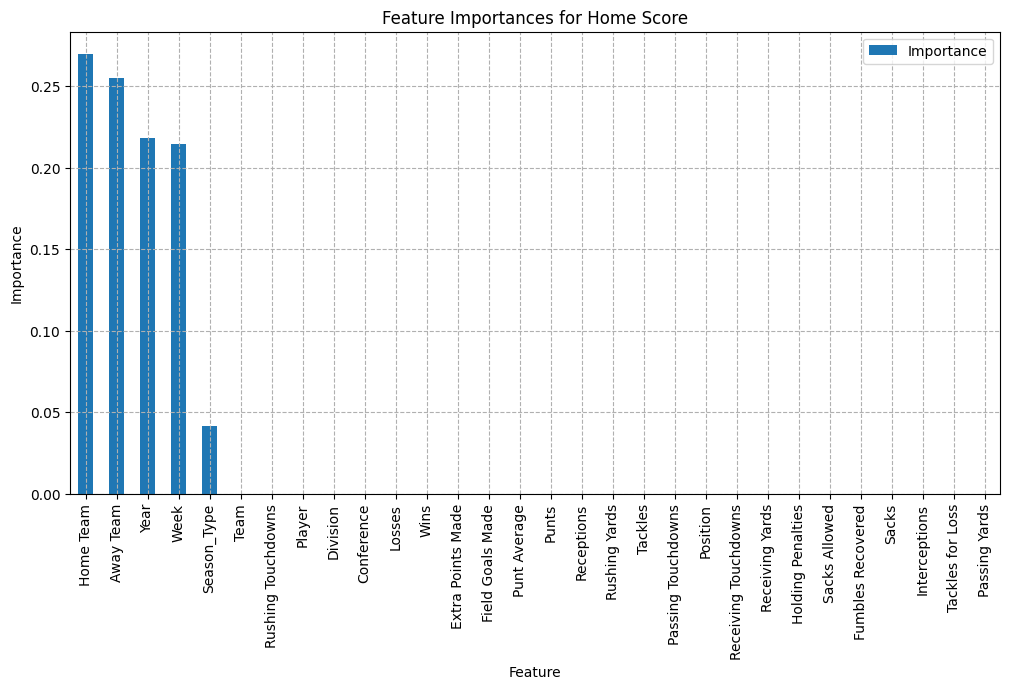

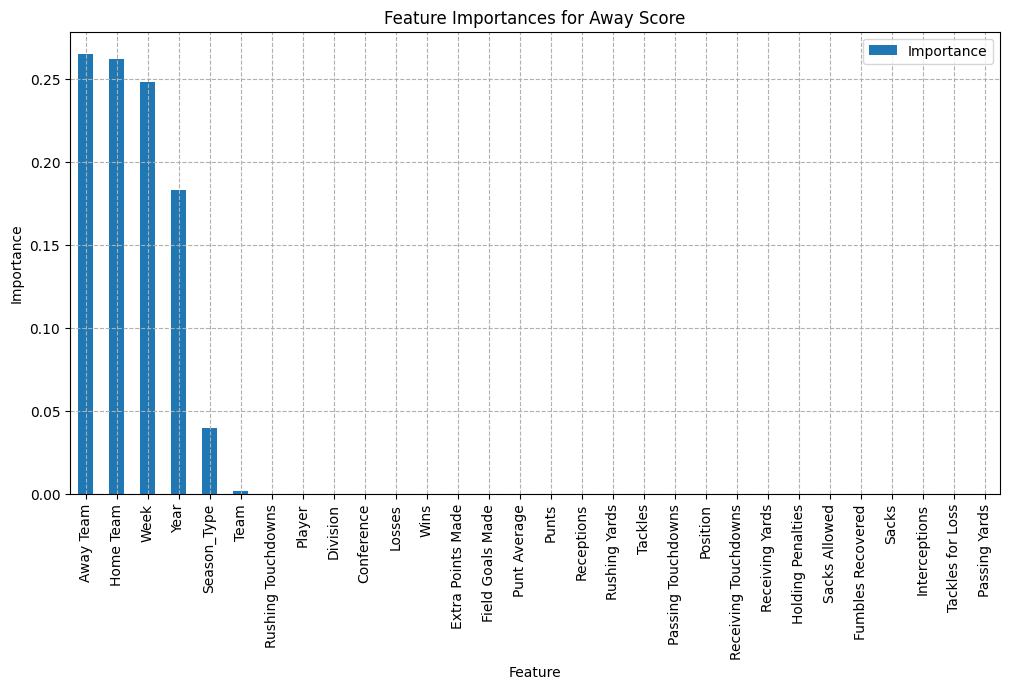

In [48]:
from sklearn.ensemble import RandomForestRegressor

model_home = RandomForestRegressor(n_estimators=100, random_state=42)
model_away = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model for Home Score
model_home.fit(X_train, y_train_home)
# Train the model for Away Score
model_away.fit(X_train, y_train_away)

# Get feature importances for both models
importances_home = pd.DataFrame({'Feature': X_train.columns, 'Importance': model_home.feature_importances_})
importances_away = pd.DataFrame({'Feature': X_train.columns, 'Importance': model_away.feature_importances_})

# Sort and display importances
importances_home = importances_home.sort_values(by='Importance', ascending=False)
importances_away = importances_away.sort_values(by='Importance', ascending=False)

print("Feature Importances for Home Score:")
print(importances_home)
print("\nFeature Importances for Away Score:")
print(importances_away)

# Plotting feature importances for Home Score
importances_home.set_index('Feature').plot(kind='bar', title='Feature Importances for Home Score', figsize=(12, 6))
plt.ylabel('Importance')
plt.grid(True, linestyle='--')
plt.show()

# Plotting feature importances for Away Score
importances_away.set_index('Feature').plot(kind='bar', title='Feature Importances for Away Score', figsize=(12, 6))
plt.ylabel('Importance')
plt.grid(True, linestyle='--')
plt.show()

****



# **Lasso Regression**


Lasso Regression is a type of linear regression that uses shrinkage. Shrinkage is where data values are shrunk towards a central point, like the mean. The lasso procedure encourages simple, sparse models (models with fewer parameters). This particular type of regression is well-suited for models showing high levels of multicollinearity or when you want to automate certain parts of model selection, like variable selection/parameter elimination. Also, Lasso regression is particularly suitable for datasets where the relationship between the independent variables and the dependent variable is linear.


$$
\min_{\beta} \left\{ \frac{1}{2n} \sum_{i=1}^{n} (y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij})^2 + \lambda \sum_{j=1}^{p} |\beta_j| \right\}
$$

where:
- $y_i$ is the observed response for the $i$th observation.
- $\beta_0$ is the intercept term.
- $\beta_j$ is the coefficient of the $j$th predictor.
- $x_{ij}$ is the value of the $j$th predictor for the $i$th observation.
- $n$ is the total number of observations.
- $p$ is the total number of predictors.
- $\lambda$ is the tuning parameter that controls the strength of the penalty term, which in turn controls the amount of shrinkage applied to the coefficients.

As $\lambda$ increases, more coefficients are set to zero, which results in a simpler and sparser model. The Lasso penalty term causes some coefficients to shrink towards zero and others to be exactly zero. This property can be used for variable selection or feature selection within a model.



****

Optimal alpha: 0.03944206059437656
Lasso Coefficients:
        Feature  Coefficient
0          Week     0.097949
29  Season_Type    -0.059448
2     Away Team    -0.237190


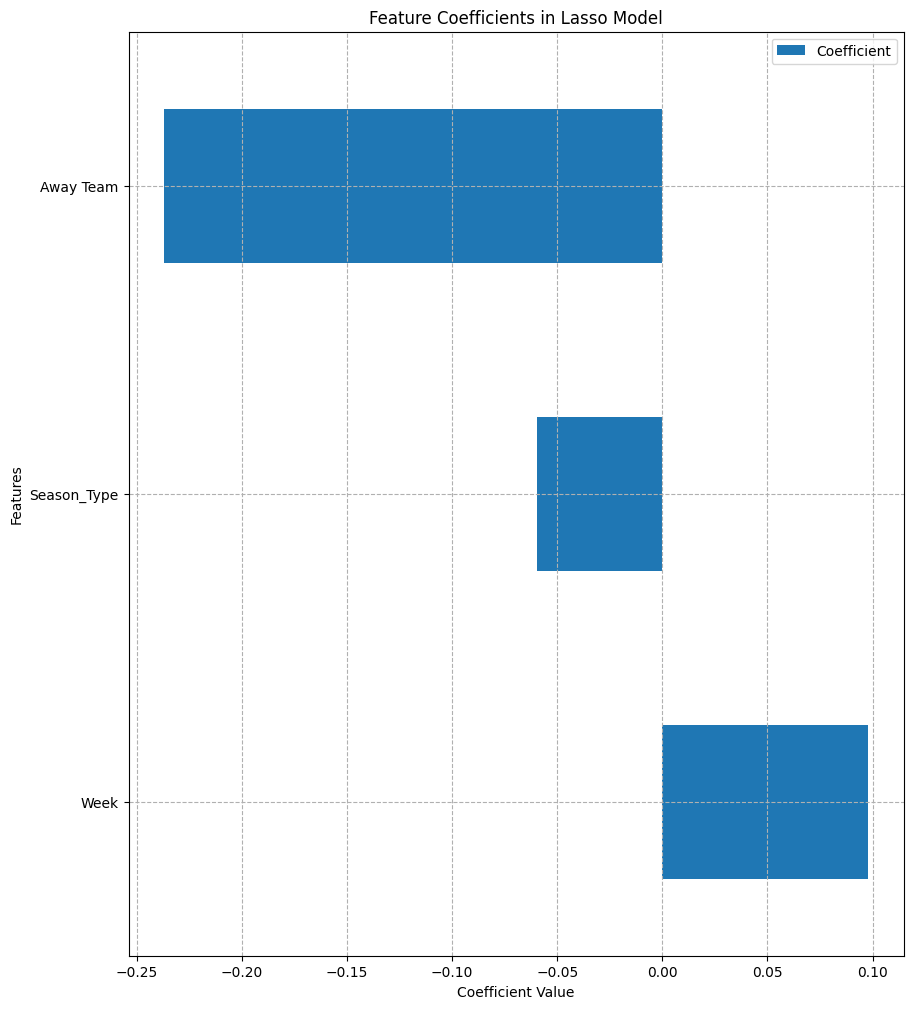

Selected features based on threshold:
['Week', 'Season_Type', 'Away Team']


In [50]:
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

categorical_cols = combined_df_sorted.select_dtypes(include=['object']).columns
combined_df_sorted[categorical_cols] = combined_df_sorted[categorical_cols].apply(lambda col: pd.factorize(col)[0])

X = combined_df_sorted.drop(['Home Score', 'Away Score'], axis=1)
y_home = combined_df_sorted['Home Score'].fillna(0)

X_train, X_test, y_train_home, y_test_home = train_test_split(X, y_home, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso_cv = LassoCV(alphas=np.logspace(-6, 1, 100), cv=5, random_state=42)
lasso_cv.fit(X_train_scaled, y_train_home)
optimal_alpha = lasso_cv.alpha_
print(f"Optimal alpha: {optimal_alpha}")

lasso = Lasso(alpha=optimal_alpha)
lasso.fit(X_train_scaled, y_train_home)

lasso_coef = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': lasso.coef_})
lasso_coef = lasso_coef[lasso_coef['Coefficient'] != 0]
lasso_coef = lasso_coef.sort_values(by='Coefficient', ascending=False)

print("Lasso Coefficients:")
print(lasso_coef)

lasso_coef.plot(kind='barh', x='Feature', y='Coefficient', title='Feature Coefficients in Lasso Model', figsize=(10, 12))
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.grid(True, linestyle='--')
plt.show()

threshold = 0.001
selected_features = lasso_coef[lasso_coef['Coefficient'].abs() > threshold]['Feature'].tolist()
print("Selected features based on threshold:")
print(selected_features)

****

# **Gradient Boosting Machine (GBM)**


****

In [51]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = combined_df_sorted[['Home Score', 'Away Score']]
y_home = combined_df_sorted['Home Score']
y_away = combined_df_sorted['Away Score']

X_train, X_test, y_train_home, y_test_home = train_test_split(X, y_home, test_size=0.2, random_state=42)
_, _, y_train_away, y_test_away = train_test_split(X, y_away, test_size=0.2, random_state=42)

gbm_home = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbm_home.fit(X_train, y_train_home)

gbm_away = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbm_away.fit(X_train, y_train_away)

home_score_pred = gbm_home.predict(X_test)
away_score_pred = gbm_away.predict(X_test)

mse_home = mean_squared_error(y_test_home, home_score_pred)
mse_away = mean_squared_error(y_test_away, away_score_pred)

print(f"Mean Squared Error for Home Score Predictions: {mse_home}")
print(f"Mean Squared Error for Away Score Predictions: {mse_away}")

Mean Squared Error for Home Score Predictions: 7.119196277620117e-05
Mean Squared Error for Away Score Predictions: 0.007959790314074885


****

# **XGBoost Model**


****

In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

X = combined_df_sorted[['Home Score', 'Away Score']]
y_home = combined_df_sorted['Home Score']
y_away = combined_df_sorted['Away Score']

X_train, X_test, y_train_home, y_test_home = train_test_split(X, y_home, test_size=0.2, random_state=42)
_, _, y_train_away, y_test_away = train_test_split(X, y_away, test_size=0.2, random_state=42)

xgb_home = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_home.fit(X_train, y_train_home)

xgb_away = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_away.fit(X_train, y_train_away)

home_score_pred_xgb = xgb_home.predict(X_test)
away_score_pred_xgb = xgb_away.predict(X_test)

mse_home_xgb = mean_squared_error(y_test_home, home_score_pred_xgb)
mse_away_xgb = mean_squared_error(y_test_away, away_score_pred_xgb)

print(f"XGBoost Mean Squared Error for Home Score Predictions: {mse_home_xgb}")
print(f"XGBoost Mean Squared Error for Away Score Predictions: {mse_away_xgb}")


XGBoost Mean Squared Error for Home Score Predictions: 0.00011383857187194107
XGBoost Mean Squared Error for Away Score Predictions: 0.008278632633491692


****

# **Bayesian Optimization for GBM**

****

Mean Squared Error for Home Score Predictions: 5.19755528929588e-08
Mean Squared Error for Away Score Predictions: 0.00783185656091119


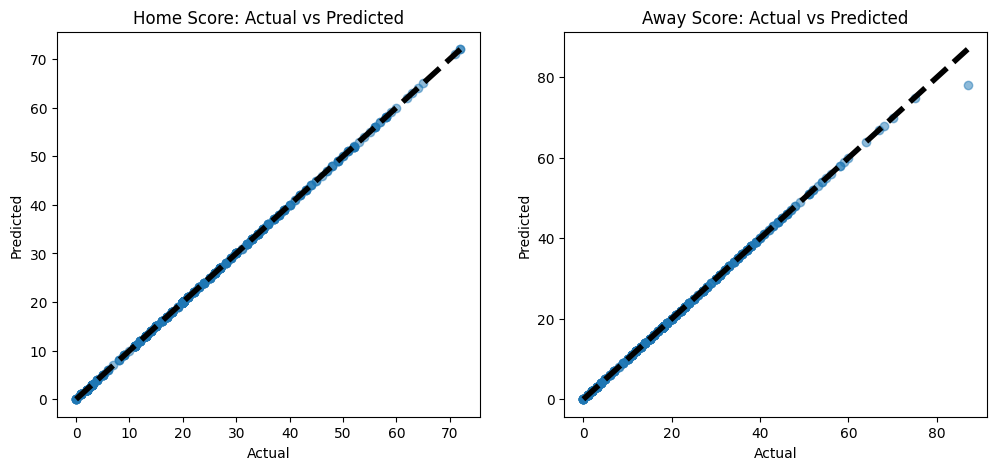

In [27]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import matplotlib.pyplot as plt
import os

os.environ["OMP_NUM_THREADS"] = "1"

def gbm_hyperparameter_tuning(X, y_home, y_away):
    global X_train_home, X_train_away, y_train_home, y_train_away

    X_train_home, X_test_home, y_train_home, y_test_home = train_test_split(X, y_home, test_size=0.2, random_state=42)
    X_train_away, X_test_away, y_train_away, y_test_away = train_test_split(X, y_away, test_size=0.2, random_state=42)

    param_space = {
        'n_estimators': Integer(50, 1000),
        'learning_rate': Real(0.001, 0.3),
        'max_depth': Integer(2, 25)
    }

    bayes_search_home = BayesSearchCV(
        estimator=GradientBoostingRegressor(),
        search_spaces=param_space,
        n_iter=50,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=1
    )

    bayes_search_away = BayesSearchCV(
        estimator=GradientBoostingRegressor(),
        search_spaces=param_space,
        n_iter=50,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=1
    )

    bayes_search_home.fit(X_train_home, y_train_home)
    bayes_search_away.fit(X_train_away, y_train_away)

    best_params_home = bayes_search_home.best_params_
    best_params_away = bayes_search_away.best_params_

    gbm_home = GradientBoostingRegressor(**best_params_home, random_state=42)
    gbm_home.fit(X_train_home, y_train_home)

    gbm_away = GradientBoostingRegressor(**best_params_away, random_state=42)
    gbm_away.fit(X_train_away, y_train_away)

    home_score_pred = gbm_home.predict(X_test_home)
    away_score_pred = gbm_away.predict(X_test_away)

    mse_home = mean_squared_error(y_test_home, home_score_pred)
    mse_away = mean_squared_error(y_test_away, away_score_pred)

    print(f"Mean Squared Error for Home Score Predictions: {mse_home}")
    print(f"Mean Squared Error for Away Score Predictions: {mse_away}")

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(y_test_home, home_score_pred, alpha=0.5)
    plt.plot([y_test_home.min(), y_test_home.max()], [y_test_home.min(), y_test_home.max()], 'k--', lw=4)
    plt.title('Home Score: Actual vs Predicted')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

    plt.subplot(1, 2, 2)
    plt.scatter(y_test_away, away_score_pred, alpha=0.5)
    plt.plot([y_test_away.min(), y_test_away.max()], [y_test_away.min(), y_test_away.max()], 'k--', lw=4)
    plt.title('Away Score: Actual vs Predicted')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.grid(True, linestyle='--')
    plt.show()

X = combined_df_sorted[['Home Score', 'Away Score']]
y_home = combined_df_sorted['Home Score']
y_away = combined_df_sorted['Away Score']

gbm_hyperparameter_tuning(X, y_home, y_away)


LSTM HYPERBAND

In [28]:
import pandas as pd
import numpy as np
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

def build_model(hp, input_shape):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=4, max_value=512, step=8),
                   input_shape=input_shape, return_sequences=False))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.01, max_value=0.8, step=0.05)))
    model.add(Dense(2, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def lstm_hyperband_model(X_train, X_test, y_train, y_test):
    if len(X_train.shape) < 3:
        X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    tuner = kt.Hyperband(
        lambda hp: build_model(hp, input_shape=(1, X_train.shape[2])),
        objective='val_loss',
        max_epochs=100,
        factor=3,
        seed=42,
        hyperband_iterations=2,
        directory='hyperband_trials',
        project_name='lstm_tuning12'
    )

    tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=100, callbacks=[early_stopping])
    best_model = tuner.get_best_models(num_models=1)[0]

    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
    print(f"Mean Squared Error for Home Score Predictions: {mse[0]}")
    print(f"Mean Squared Error for Away Score Predictions: {mse[1]}")

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(y_test[:, 0], y_pred[:, 0], alpha=0.5)
    plt.plot([y_test[:, 0].min(), y_test[:, 0].max()], [y_test[:, 0].min(), y_test[:, 0].max()], 'k--', lw=4)
    plt.title('Home Score: Actual vs Predicted')
    plt.xlabel('Actual Home Score')
    plt.ylabel('Predicted Home Score')

    plt.subplot(1, 2, 2)
    plt.scatter(y_test[:, 1], y_pred[:, 1], alpha=0.5)
    plt.plot([y_test[:, 1].min(), y_test[:, 1].max()], [y_test[:, 1].min(), y_test[:, 1].max()], 'k--', lw=4)
    plt.title('Away Score: Actual vs Predicted')
    plt.xlabel('Actual Away Score')
    plt.ylabel('Predicted Away Score')

    plt.show()

    history = tuner.oracle.get_best_trials(num_trials=1)[0].metrics.get_history()
    val_loss = [entry['val_loss'] for entry in history]
    loss = [entry['loss'] for entry in history]

    plt.figure(figsize=(10, 5))
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.show()

    return best_model

X = combined_df_sorted[['Home Score', 'Away Score']].values
y = combined_df_sorted[['Home Score', 'Away Score']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

if len(X_train.shape) == 2:
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

best_model = lstm_hyperband_model(X_train, X_test, y_train, y_test)

Trial 78 Complete [00h 00m 53s]
val_loss: 0.37569013237953186

Best val_loss So Far: 0.25060826539993286
Total elapsed time: 00h 51m 54s

Search: Running Trial #79

Value             |Best Value So Far |Hyperparameter
204               |492               |units
0.31              |0.01              |dropout_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2


KeyboardInterrupt: 